### HW 3-1. DQN for Traffic Light Control

Please write down the codes for DQN algorithm on this file. Also, add your comment with the result here,

## Import Libraries and check for GPU

In [1]:
### DQN ###
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import math
import random
import numpy as np

from itertools import count
from collections import namedtuple

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Import Traci and other SUMO's Tools

In [2]:
import os, sys
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

## Transition and ReplayMemory
-------

**Transitions** are a tuple of `before state`, `action`, `reward`, `state` and `done` which gathered after each exprience step in SUMO.

**Replay Memory** is a Class to store and sample transitions.

In [3]:
Transition = namedtuple('Transition',('before_state', 'action', 'reward', 'state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN Model

In [4]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.action_dim = action_dim
        self.state_dime = state_dim
        
        h1 = 20
        h2 = 10
        
        self.h1 = nn.Linear(state_dim, h1)
        self.h2 = nn.Linear(h1, h2)
        
        self.head = nn.Linear(h2, action_dim)
        
    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        return self.head(x)

## DQN Agent

In [5]:
class DQNAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNAgent, self).__init__()
        
        self.policy_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        
        self.memory = ReplayMemory(2**10)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()
    
        self.optimizer = optim.RMSprop(self.policy_network.parameters())
                
        self.batch_size = 128
        self.gamma = 0.999
        self.target_update = 4000
        self.num_train = 0
    
    def forward(self,x):
        with torch.no_grad():
            return self.policy_network(x)
    
    def train(self):
        self.num_train += 1
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.state if s is not None])
        
        state_batch = torch.cat(batch.before_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        q = self.policy_network(state_batch).gather(1, action_batch).squeeze(1)

        y = torch.zeros(self.batch_size, device=device)
        y[non_final_mask] = self.target_network(non_final_next_states).max(1)[0].detach() * self.gamma
        y += reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(y, q)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_network.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        if self.num_train % self.target_update == 0:
            self.update_target()
        
        return loss.item()
    
    def train_start(self):
        return len(self.memory) > self.batch_size # Boolean
    
    def update_target(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()
    
    def save_memory(self, transition):
        transition[1] = torch.tensor([[transition[1]]], device=device, dtype=torch.long) # Action
        transition[2] = torch.tensor([transition[2]], device=device) # Reward
        self.memory.push(*transition)

In [6]:
### Training (Do not revise this code) ###
from SUMO.TrafficEnv_DQN import TrafficEnv

import torch
import random
import numpy as np
import matplotlib.pyplot as plt

def main_DQN() :

    exp_dir = './SUMO/Single_Intersection'
    exp_type = 'binary'

    max_episode = 300
    max_epi_step = 800

    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    state_dim = 12
    action_dim = 2
    
    env = TrafficEnv(exp_dir, exp_type)
    agent = DQNAgent(state_dim, action_dim)

    loss_list = []
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).reshape(-1, state_dim)

        loss_epi = []
        reward_epi = []
        action = None

        for epi_step in range(max_epi_step):

            # make an action based on epsilon greedy action
            before_action = action

            if random.random() < epsilon:
                action = random.randint(0, action_dim - 1)
            else:
                action = agent(state)
                action = np.argmax(action.detach().cpu().numpy())
            before_state = state

            state, reward, done = env.step(action)
            
            state = torch.tensor(state, dtype=torch.float32, device=device).reshape(-1, state_dim)
            reward_epi.append(reward)
            
            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                loss = agent.train()
                loss_epi.append(loss)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        if agent.train_start():
            loss_list.append(sum(loss_epi)/len(loss_epi))

        env.close()
        reward_list.append(sum(reward_epi))

        if agent.train_start():
            print(episode+1, reward_list[-1], loss_list[-1])

    return loss_list, reward_list


if __name__ == "__main__":

    loss_list, reward_list = main_DQN()

    plt.plot(loss_list)
    plt.title("Loss of DQN Agent")
    plt.savefig("./Visualization/DQN/loss3.png")
    plt.close('all')

    plt.plot(reward_list)
    plt.title("Reward of DQN Agent")
    plt.savefig("./Visualization/DQN/reward3.png")
    plt.close('all')

 Retrying in 1 seconds
 Retrying in 1 seconds
2 -591 1.4077475239248838
 Retrying in 1 seconds
3 -462 0.7949582403898239
 Retrying in 1 seconds
4 -375 0.696531522755671
 Retrying in 1 seconds
5 -570 0.6904612151431102
 Retrying in 1 seconds
6 -461 0.7211403236636575
 Retrying in 1 seconds
7 -500 0.6866087396534122
 Retrying in 1 seconds
8 -623 0.7164087094822709
 Retrying in 1 seconds
9 -549 0.7166372151935801
 Retrying in 1 seconds
10 -373 0.7303774245813781
 Retrying in 1 seconds
11 -489 0.7011847662816354
 Retrying in 1 seconds
12 -607 0.707858882113999
 Retrying in 1 seconds
13 -337 0.7278392624396545
 Retrying in 1 seconds
14 -634 0.741686823276373
 Retrying in 1 seconds
15 -452 0.7380021785227757
 Retrying in 1 seconds
16 -449 0.7031829697745187
 Retrying in 1 seconds
17 -381 0.7019612873063504
 Retrying in 1 seconds
18 -591 0.7086786453170005
 Retrying in 1 seconds
19 -382 0.6697238935637719
 Retrying in 1 seconds
20 -467 0.664034786298103
 Retrying in 1 seconds
21 -422 0.666050

# Results


## Reward

First I show the result of reward improvement and compare it to naive strategies (random, always one and always zero)
This comparision shows learning process improved the reward.


## Loss

Unlike supervised learning, the RL will not converge when loss decrease to zero, the loss value is just shows the diffrence between target network and policy network.

In general optimizer tries to reducde this loss, but we can see a jump in loss function every time we updated the target value.

I tried diffrent parameter for batch size and how often update the target nerwork, I found the reward might increase more stable if loss value bound inside a range and do not increase with every update. Intiutivily we should not update the target value too fast and let optimizer decrease the loss fucntion. 


### Rewards:

1. Random: Randomly choose between 0 and 1
2. Zero
3. One
4. DQN Agent

As shows in below DQN improved form -500 to -250.

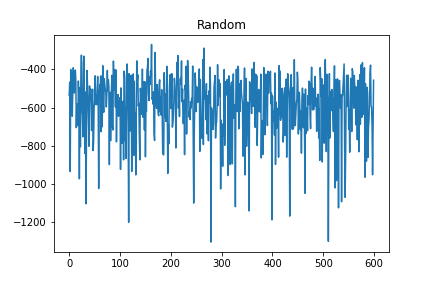

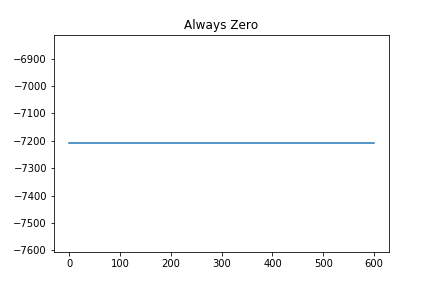

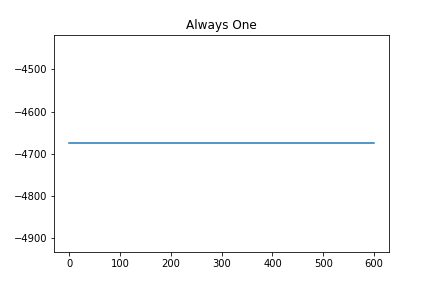

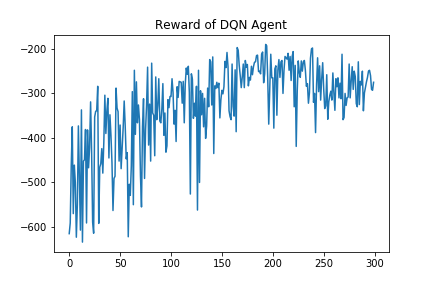

[None, None, None, None]

In [7]:
from IPython.display import Image, display

[display(Image(filename='./Visualization/DQN/' + img + '.png')) for img in ['reward_random2', 'reward_zero2', 'reward_one2', 'reward3']] 

### Loss of Learning

1. Batch: 50  - Update Target every:  450 steps
2. Batch: 100 - Update Target every: 2500 steps
3. Batch: 128 - Update Target every: 4000 steps

Overall, the loss function value does not have an important meaning we should just see it decreases in a prieod till we update the target network

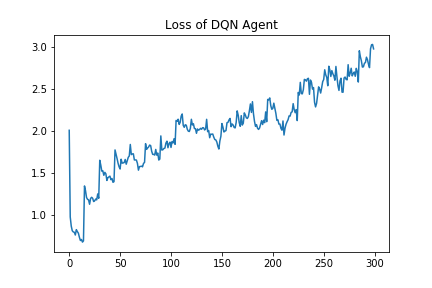

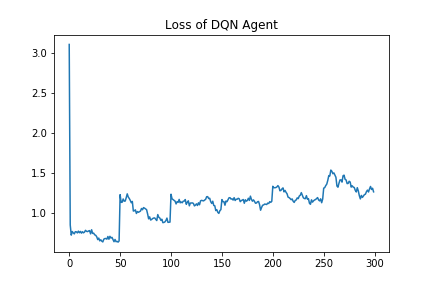

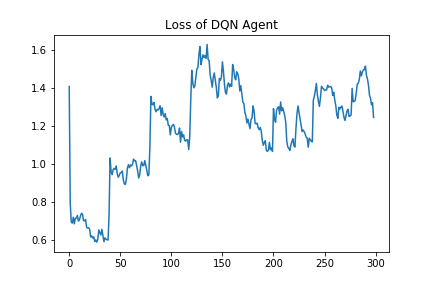

[None, None, None]

In [8]:
## Results
from IPython.display import Image, display

[display(Image(filename='./Visualization/DQN/' + img + '.png')) for img in ['loss_15_50', 'loss_50_100', 'loss3']] 